In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from osgeo import gdal

#### comparing LST temperature of JJA 2001 with PRISM

In [51]:
dir = '/glade/scratch/mingge/LST/'
flnm = [ 'LST_2021_JJA-maximum.tif', 'LST_2021_JJA-mean.tif', 'LST_2021_JJA-median.tif']

In [52]:
# insert a image of LST data domain here
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://mail.google.com/mail/u/0?ui=2&ik=4123481561&attid=0.1&permmsgid=msg-f:1738723476189794376&th=18212fca18ecd048&view=fimg&fur=ip&sz=s0-l75-ft&attbid=ANGjdJ_HHHckqQgdwjIC0I93E_9k1XYkOcbj4MqV3JEfjszcu6C4cXgFZ4bJ4uuiVndrNlbnCXjT72ACq83CsPAIjGFypYhblLF92Uc_ygucjuGSggN2cPG0z94lvl0&disp=emb&realattid=ii_l5r7310p0![image.png](attachment:f7ab58d7-d11a-4ac9-aff4-d08392d221f3.png)![image.png](attachment:8839d3dc-412c-43f4-93ab-67889927250f.png)![image.png](attachment:ea6c65d7-f78f-49c8-adb0-c86e4e61f015.png")

#### read and plot Geotiff (.tif) Raster file

In [53]:
dataset = gdal.Open(dir+flnm[2])
# Counting the total number of bands.
print("There are ", dataset.RasterCount, ' band')

There are  1  band


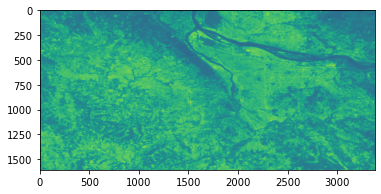

In [54]:
#Fetching the bands
band1 = dataset.GetRasterBand(1) # Red channel
b1 = np.squeeze(band1.ReadAsArray())
#img = np.squeeze(np.dstack((b1)))
plt.imshow(b1);

LST_2021_JJA-maximum.tif
LST_2021_JJA-mean.tif


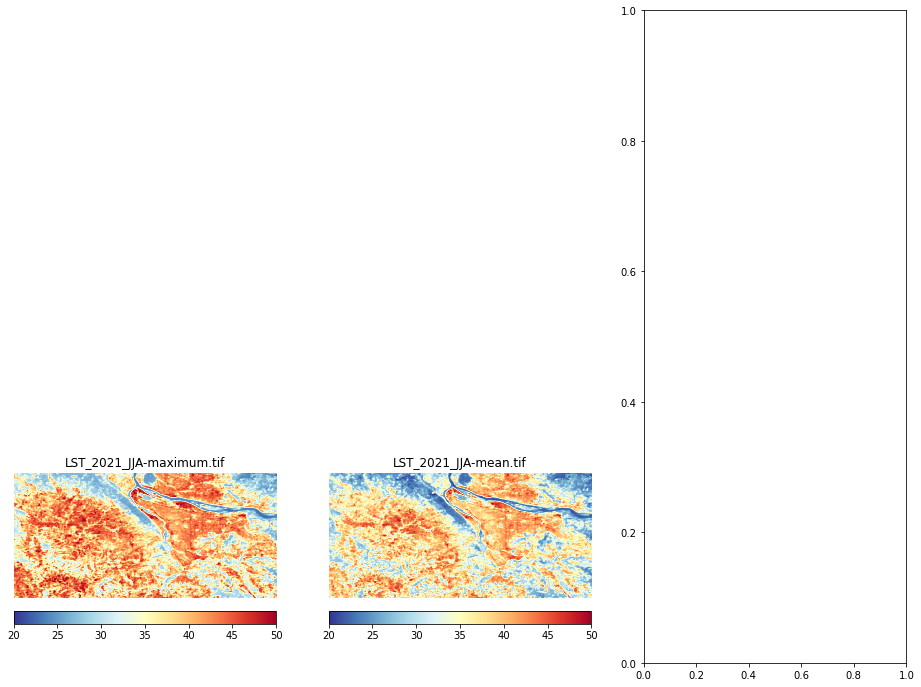

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(16, 12))
for i in range(2):
    print(flnm[i])
    dataset = gdal.Open(dir+flnm[i])
    
    #Fetching the bands
    band1 = dataset.GetRasterBand(1) # Red channel
    b1 = np.squeeze(band1.ReadAsArray())
    img = np.squeeze(np.dstack((b1)))
            
    im = ax[i].imshow(b1, vmin=20, vmax=50, cmap='RdYlBu_r')
     
    plt.colorbar(im, ax=ax[i], fraction=0.08, pad=0.02, orientation='horizontal' ) 
    ax[i].set_axis_off()
    ax[i].title.set_text(flnm[i])
     
plt.show()
fig.savefig('lst.png')

#### read and plot PRISM

In [37]:
var = ['Tmax', 'T2M', 'Tmin']
dir_i = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'
flnm = ['PRISM_daily_tmax_2021.nc','PRISM_daily_tmean_2021.nc','PRISM_daily_tmin_2021.nc']

date_s = '2021-06-01'
date_e = '2021-08-31'

# LST domain
lat_s = 45.266736
lat_e = 45.700083
lon_s = -123.190017
lon_e = -122.279934

for i in range(len(flnm)):
    with xr.open_dataset(dir_i + var[i] + '/' + flnm[i]) as ds_prism:
            print(dir_i + var[i] + '/' + flnm[i])
            if var[i]=='Tmax':
              t_max = ds_prism.Tmax.sel(time=slice(date_s, date_e),
                         rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e)).mean(axis=0)
            elif var[i]=='T2M':
              t_mean = ds_prism.T2M.sel(time=slice(date_s, date_e),
                         rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e)).mean(axis=0)
            elif var[i]=='Tmin':
              t_min = ds_prism.Tmin.sel(time=slice(date_s, date_e),
                         rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e)).mean(axis=0)
                

/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmax/PRISM_daily_tmax_2021.nc
/glade/campaign/mmm/c3we/prein/observations/PRISM/data/T2M/PRISM_daily_tmean_2021.nc
/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmin/PRISM_daily_tmin_2021.nc


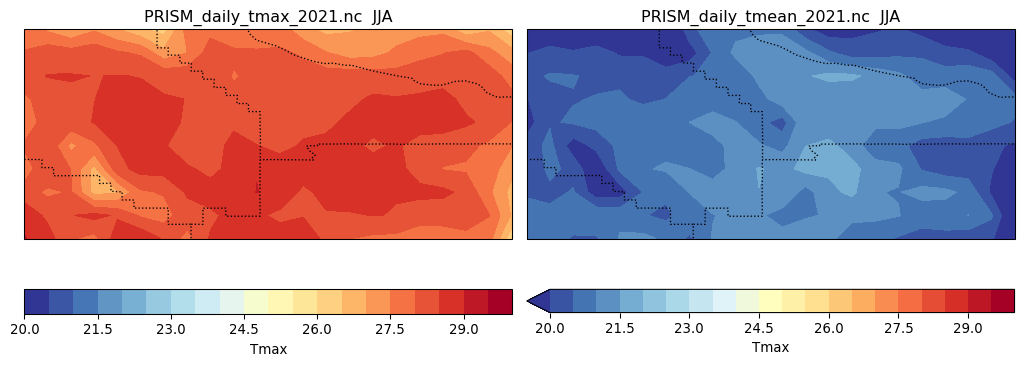

In [47]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize=(16,4), dpi=96)

# James asked for adding county line, Given cartopy's ability to draw shapefiles,
# I download one of those county shapefiles:
# https://prd-tnm.s3.amazonaws.com/StagedProducts/Small-scale/data/Boundaries/countyl010g_shp_nt00964.tar.gz
reader = shpreader.Reader('/glade/work/mingge/SHAPEFILES/COUNTY_OREGON/countyl010g.shp')

counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

cnlevel = np.linspace(11, 60, num=50)

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))
    
t_3d = xr.concat([t_max, t_mean, t_min ], dim='variables')

for i in range(2):
        if i == 0:
            cnlevel = np.linspace(20, 30, num=21)
        
        ax_s = plt.subplot(1, 3, i+1, projection=ccrs.PlateCarree())
        ax_coastlines_country(ax_s)
        ax_s.add_feature(COUNTIES, facecolor='none', edgecolor='black', linestyle=':')

        im=t_3d[i].plot.contourf(
            levels=cnlevel,
            #vmin = 20,
            #vmax = 50,
            cmap='RdYlBu_r',
            ax=ax_s,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={'orientation': 'horizontal'},
            add_colorbar=True)
         
        plt.title(flnm[i] + '  JJA')

plt.tight_layout()
fig.savefig('prism.png')
